In [1284]:
!pip install num2words
!pip install textblob

In [1285]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
# POS tag
from nltk import pos_tag
nltk.download('popular')
# numbers to words
from num2words import num2words
# import ngrams
from nltk.util import ngrams
# import math
import math
# import textblob
from textblob import TextBlob
from sklearn.feature_extraction import DictVectorizer
# import word2vec
from gensim.models import Word2Vec
# import sid
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline
pd.options.display.max_colwidth=500

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/samson/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/samson/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/samson/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/samson/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/samson/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/samson/nltk_data...
[nltk_data]    |   Package movie_reviews is already

In [1286]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [1287]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # need to sort to ensure same initial order

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [1288]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [1289]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [1290]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [1291]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [1292]:
# # Create one document per character
# def create_character_document_from_dataframe(df, max_line_count):
#     """Returns a dict with the name of the character as key,
#     their lines joined together as a single string, with end of line _EOL_
#     markers between them.
    
#     ::max_line_count:: the maximum number of lines to be added per character
#     """
#     character_docs = {}
#     character_line_count = {}
#     for line, name, episode, scene in zip(range(len(df.Line)), df.Character_name, df.Episode, df.Scene):
#         if not name in character_docs.keys():
#             character_docs[name] = ""
#             character_line_count[name] = 0
#         if character_line_count[name]==max_line_count:
#             continue
#         # for line in the same scene
#         if line > 0 and df.Episode.iloc[line-1] == episode and df.Scene.iloc[line-1] == scene:
#             character_docs[name] += str(df.Line.iloc[line-1]) + "_EOL_ "
#         character_docs[name] += str(df.Line.iloc[line])  + " _EOL_ "
#         if line < len(df.Line)-1 and df.Episode.iloc[line+1] == episode and df.Scene.iloc[line+1] == scene:
#             character_docs[name] += str(df.Line.iloc[line+1])  + " _EOL_ "
#         character_line_count[name]+=1
#     print("lines per character", character_line_count)
#     return character_docs

In [1293]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  3848
OTHER Number of Words:  3244
JACK Number of Words:  4435
RONNIE Number of Words:  3442
TANYA Number of Words:  3786
SEAN Number of Words:  3637
ROXY Number of Words:  3838
HEATHER Number of Words:  4098
MAX Number of Words:  4363
IAN Number of Words:  4332
JANE Number of Words:  3648
STACEY Number of Words:  3913
PHIL Number of Words:  3635
MINTY Number of Words:  4005
CHRISTIAN Number of Words:  3738
CLARE Number of Words:  4344
total words 62306


In [1294]:
# train character docs to dataframe
train_character_docs_df = pd.DataFrame.from_dict(train_character_docs, orient='index')
train_character_docs_df = train_character_docs_df.reset_index()
train_character_docs_df.columns = ['Character_name', 'Line']
train_character_docs_df.head()

,Character_name,Line
0,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man. _EOL_ I'm gonna get help. Oh where's my phone? Oh Kevin. Kevin you smashed it, didn't ya? Kevin, Kevin, where's your phone? _EOL_ No you're not, ssh, shut up. _EOL_ Fire brigade and ambulance. There's been an accident. On an industrial estate in Walford. ...Um, the Marsh Lane industrial estate. Please come quick. My husband- he's not my husband- my friend. He's trapped in the car. Please come quick... Shirley Carter. 82 82B G..."
1,OTHER,"Shirl... _EOL_ Where you going? _EOL_ In my right pocket. _EOL_ I'm done for. _EOL_ I'm done for. _EOL_ No. _EOL_ Don't go Shirl. I'm not going to make it. _EOL_ No I ain't got five minutes. I, I ain't got it. You just, you just sit there with me please. I don't want to go on my own. _EOL_ Please, Shirley, for once in your life do what I ask. I'm scared. I'm scared. I'm so scared. _EOL_ Phil said he'd be alright. He's only having a shandy. _EOL_ I've had two and my legs feel funny. _EOL_ Don..."
2,JACK,"Oi. Where have you been? Huh? What were the texts about? _EOL_ Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar. _EOL_ It's on the house. Are you alright? _EOL_ I left the night wallet at home. I'm gonna be about ten minutes. _EOL_ Are you alright? You've been a bit off since you got here. _EOL_ So that's why you were late? You had a little set up planned? _EOL_ Well, how about I pour you a glass of this and take you through what might've h..."
3,RONNIE,"Nothing. Nothing. I'll be with you in two minutes yeah? _EOL_ Alright. Two minutes. _EOL_ Okay. _EOL_ Proper little detective aren't you? _EOL_ I'd have drunk it. _EOL_ I'm doing all the work here Jack, that doesn't bode _EOL_ What moment's that then? _EOL_ Oi. What the hell is going on here? _EOL_ Listen, you have been spoiling for this all night. Home, now. _EOL_ Get out. _EOL_ Course not. I'm sorry about Jase. _EOL_ I think I've got someone in line already. _EOL_ Nah. He'll keep. _EOL_ 20..."
4,TANYA,"Another drink? _EOL_ Lightweight. Let's see what we got over here shall we? Oh look it's 21 year old whisky. Let's have that shall we? Max prefers them younger. _EOL_ That's my Seany Sean Sean. No point going to bed early on New Year's Eve is there? _EOL_ Yep. _EOL_ Well, I wanted us all to be together. _EOL_ That's a Mother's perogative. Go and get your jim-jams on- we can all watch big ben together with a tub of ice-cream. Bye. _EOL_ I don't want to hear any of your crap. Just get out of t..."


In [1295]:
# print head of train_character_docs
for name in train_character_docs.keys():
    print(name, train_character_docs[name][:1000])
    break

# # print tail of train_character_docs
# for name in train_character_docs.keys():
#     print(name, train_character_docs[name][-1000:])
#     break

SHIRLEY Look at ya, not a mark on ya. And you think you're an unlucky man. _EOL_ I'm gonna get help. Oh where's my phone? Oh Kevin. Kevin you smashed it, didn't ya? Kevin, Kevin, where's your phone? _EOL_ No you're not, ssh, shut up. _EOL_ Fire brigade and ambulance. There's been an accident. On an industrial estate in Walford. ...Um, the Marsh Lane industrial estate. Please come quick. My husband- he's not my husband- my friend. He's trapped in the car. Please come quick... Shirley Carter. 82 82B George Street, Walford, E20. Please hurry, please come quick. _EOL_ Kevin. Kevin! _EOL_ Kevin I'm gonna go to the main road - _EOL_ To make sure they know where to go. _EOL_ Kevin I'll be five minutes. _EOL_ You'll be fine. You're talking. I'll be five minutes. _EOL_ It's alright, it's alright, it's alright, it's alright. _EOL_ Go away. _EOL_ I don't know what to say. It's a nightmare. _EOL_ He asked me to go with him. _EOL_ Yeah. _EOL_ Between us? Of course not. _EOL_ We just went to get Yol

In [1296]:
# find most common words from Shirley
train_character_docs['SHIRLEY'].split().count('')

0

In [1297]:
# def pre_process(character_text):
#     """Pre-process all the concatenated lines of a character, 
#     using tokenization, spelling normalization and other techniques.
    
#     Initially just a tokenization on white space. Improve this for Q1.
    
#     ::character_text:: a string with all of one character's lines
#     """
#     tokens = character_text.split()   # just a simple tokenization, to be replaced
#     return tokens

In [1298]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    # split on white space 
    tokens = re.split('\W+', character_text)
    
    # convert to lower case
    tokens = [t.lower() for t in tokens]
    
    # convert numbers to words (e.g. 1 -> one)
    tokens = [num2words(int(t)) if t.isdigit() else t for t in tokens]

    # remove tokens with non-alphabetic characters
    tokens = [t for t in tokens if t.isalpha()]

    # lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # stem tokens
    porter = PorterStemmer()
    tokens = [porter.stem(t) for t in tokens]
    
    # remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    
    return tokens

In [1299]:
pre_process('Hello 1 2 3 4 5 6 7 8 9 10')

['hello',
 'one',
 'two',
 'three',
 'four',
 'five',
 'six',
 'seven',
 'eight',
 'nine',
 'ten']

In [1300]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [1301]:
training_corpus[1]

('CLARE',
 ['dot',
  'dot',
  'dot',
  'peopl',
  'still',
  'use',
  'thi',
  'place',
  'paulin',
  'someth',
  'like',
  'wait',
  'someon',
  'fella',
  'run',
  'thi',
  'place',
  'doe',
  'still',
  'live',
  'round',
  'bit',
  'comedown',
  'one',
  'rememb',
  'bacon',
  'sandwich',
  'pleas',
  'realli',
  'listen',
  'er',
  'suppos',
  'could',
  'lend',
  'cash',
  'ya',
  'get',
  'paulin',
  'come',
  'ian',
  'chuck',
  'sonia',
  'cafe',
  'enough',
  'time',
  'littl',
  'tri',
  'call',
  'dot',
  'boyfriend',
  'ex',
  'boyfriend',
  'need',
  'somewher',
  'clean',
  'pleas',
  'ian',
  'got',
  'nowher',
  'els',
  'go',
  'mean',
  'soon',
  'got',
  'cash',
  'next',
  'train',
  'look',
  'gotta',
  'go',
  'sorri',
  'hope',
  'mind',
  'alright',
  'ian',
  'seem',
  'bit',
  'fluster',
  'thi',
  'paulin',
  'old',
  'stuff',
  'well',
  'thi',
  'bit',
  'dull',
  'right',
  'look',
  'ian',
  'realli',
  'appreci',
  'thi',
  'le',
  'repay',
  'favour',


In [1302]:
# def to_feature_vector_dictionary(character_doc, extra_features):
#     """Converts a list of pre-processed tokens and extra features
#     to a Dictionary as a function of the tokens.
    
#     Initially just a simple count. Improve this for Q2.
    
#     ::character_doc:: a list of pre-processed tokens
#     ::extra_features:: any extra features for the character to be added to feature vector dict
#     """
# # tf-idf model with bigrams
# # extract n-grams
#     n_grams = []
#     for i in range(1, 3):
#         n_grams += list(ngrams(character_doc, i))
#     counts = Counter(n_grams)  # for now a simple count
#     counts = dict(counts)
#     # tf-idf
#     tf = {k: v/len(character_doc) for k, v in counts.items()}
#     idf = {k: math.log(len(character_doc)/v) for k, v in counts.items()}
#     tf_idf = {k: v*idf[k] for k, v in tf.items()}
#     counts = tf_idf
#     return counts

In [1303]:
def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    # extract bigrams and unigrams
    unigrams = Counter(character_doc)
    unigrams = dict(unigrams)
    # extract bigrams
    bigrams = list(ngrams(character_doc, 2))
    bigrams = [b[0] + '_' + b[1] for b in bigrams]
    bigrams = Counter(bigrams)
    bigrams = dict(bigrams)
    # make unigrams into a Counter
    counts = Counter(unigrams)
    counts = dict(counts)
    # remove underscores from bigrams
    bigrams = {k.replace('_', ' '): v for k, v in bigrams.items()}
    # combine unigrams and bigrams
    counts.update(bigrams)
    return counts


In [1304]:
to_feature_vector_dictionary(training_corpus[1][1], [])

{'dot': 21,
 'peopl': 3,
 'still': 5,
 'use': 6,
 'thi': 28,
 'place': 7,
 'paulin': 3,
 'someth': 7,
 'like': 27,
 'wait': 7,
 'someon': 6,
 'fella': 1,
 'run': 2,
 'doe': 1,
 'live': 1,
 'round': 4,
 'bit': 11,
 'comedown': 1,
 'one': 16,
 'rememb': 3,
 'bacon': 1,
 'sandwich': 1,
 'pleas': 9,
 'realli': 24,
 'listen': 4,
 'er': 3,
 'suppos': 4,
 'could': 18,
 'lend': 1,
 'cash': 3,
 'ya': 1,
 'get': 43,
 'come': 16,
 'ian': 12,
 'chuck': 1,
 'sonia': 1,
 'cafe': 3,
 'enough': 3,
 'time': 19,
 'littl': 3,
 'tri': 5,
 'call': 4,
 'boyfriend': 4,
 'ex': 2,
 'need': 18,
 'somewher': 4,
 'clean': 2,
 'got': 17,
 'nowher': 1,
 'els': 1,
 'go': 30,
 'mean': 6,
 'soon': 2,
 'next': 3,
 'train': 1,
 'look': 33,
 'gotta': 5,
 'sorri': 12,
 'hope': 6,
 'mind': 7,
 'alright': 6,
 'seem': 5,
 'fluster': 1,
 'old': 1,
 'stuff': 2,
 'well': 25,
 'dull': 1,
 'right': 10,
 'appreci': 2,
 'le': 1,
 'repay': 1,
 'favour': 2,
 'day': 6,
 'bate': 2,
 'alreadi': 3,
 'met': 2,
 'slip': 1,
 'cloth': 2,
 'k

In [1305]:
# corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# # Any matrix transformers (e.g. tf-idf transformers) should be initialized here


# def create_document_matrix_from_corpus(corpus, fitting=False):
#     """Method which fits different vectorizers
#     on data and returns a matrix.
    
#     Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
#     ::corpus:: a list of (class_label, document) pairs.
#     ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
#     """
    
#     # uses the global variable of the corpus Vectorizer to improve things
#     if fitting:
#         corpusVectorizer.fit([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
#     doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    
#     #training_feature_matrix[0].toarray()
#     return doc_feature_matrix

# training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [1306]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
# tfidfTransformer
from sklearn.feature_extraction.text import TfidfTransformer
tfidfTransformer = TfidfTransformer()

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
        tfidfTransformer.fit(corpusVectorizer.transform([to_feature_vector_dictionary(doc, []) for name, doc in corpus]))
        
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    doc_feature_matrix = tfidfTransformer.transform(doc_feature_matrix)

    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [1307]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405
total words 7062


In [1308]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [1309]:
val_feature_matrix

<16x24511 sparse matrix of type '<class 'numpy.float64'>'
	with 2758 stored elements in Compressed Sparse Row format>

In [1310]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [1311]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a anumpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [1312]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [1313]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

target: CHRISTIAN
CHRISTIAN CHRISTIAN 0.29201068962352594
CHRISTIAN CLARE 0.23969889174710074
CHRISTIAN HEATHER 0.1650609935336789
CHRISTIAN IAN 0.23463903689284843
CHRISTIAN JACK 0.20671676063075703
CHRISTIAN JANE 0.32741399748395134
CHRISTIAN MAX 0.16892227775071902
CHRISTIAN MINTY 0.16161933322803845
CHRISTIAN OTHER 0.16672152073362273
CHRISTIAN PHIL 0.1722104762475656
CHRISTIAN RONNIE 0.1676796051447745
CHRISTIAN ROXY 0.1739706820765399
CHRISTIAN SEAN 0.19189093059842588
CHRISTIAN SHIRLEY 0.17579560516918816
CHRISTIAN STACEY 0.18678878304514407
CHRISTIAN TANYA 0.1505731395453312
Ranking for target 2
target: CLARE
CLARE CHRISTIAN 0.178693811227785
CLARE CLARE 0.27178799852423097
CLARE HEATHER 0.1841483863447877
CLARE IAN 0.19854198785724195
CLARE JACK 0.2248291489329516
CLARE JANE 0.18422293006424065
CLARE MAX 0.2212797953207879
CLARE MINTY 0.20033180884559518
CLARE OTHER 0.20219414248870812
CLARE PHIL 0.17622382535682377
CLARE RONNIE 0.21343699743418493
CLARE ROXY 0.232510129540569

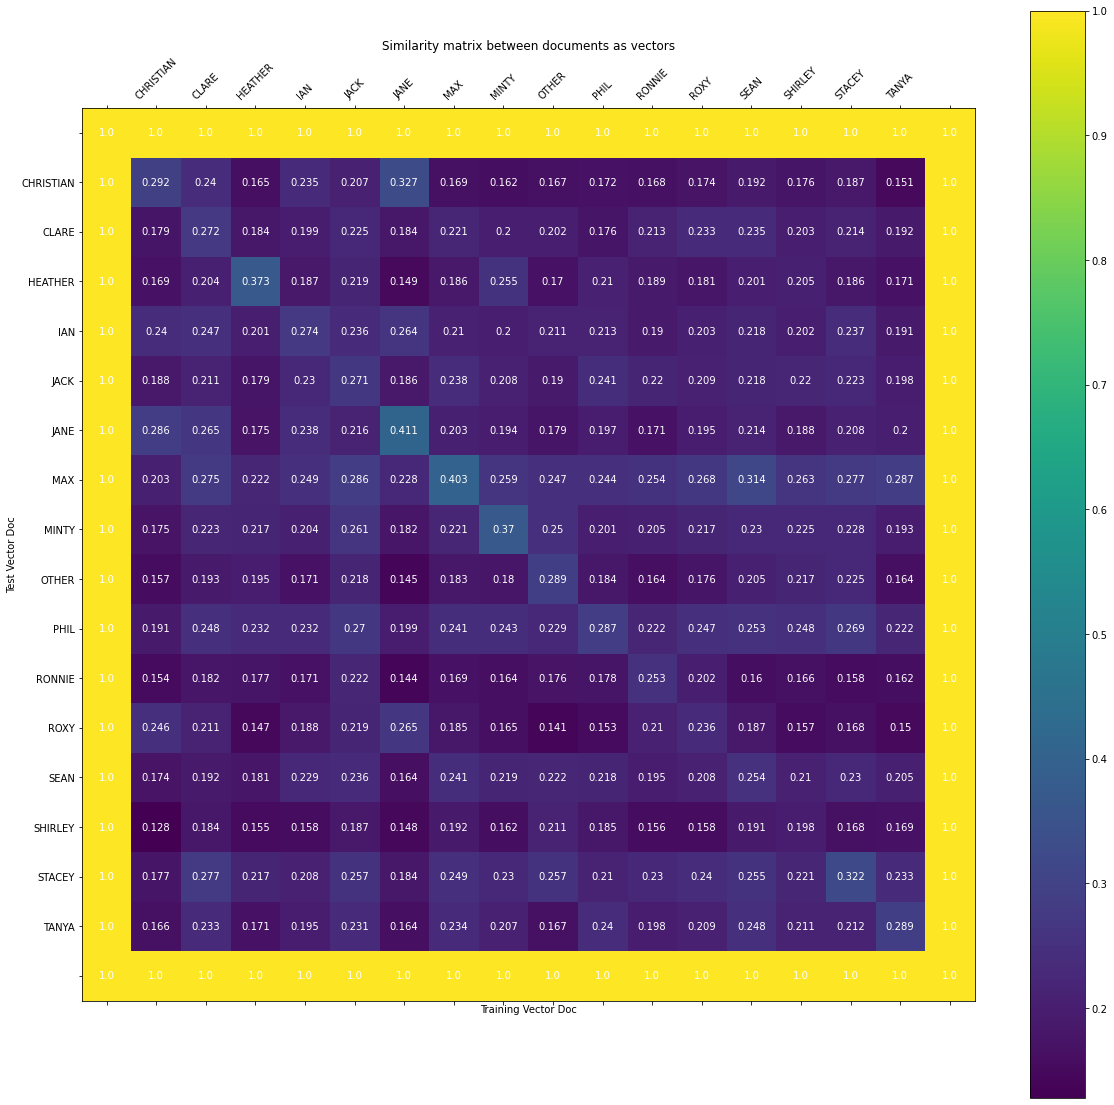

In [1314]:
plot_heat_map_similarity(df)

In [1315]:
df.head()

,doc1,doc2,similarity
0,CHRISTIAN,CHRISTIAN,0.292011
1,CHRISTIAN,CLARE,0.239699
2,CHRISTIAN,HEATHER,0.165061
3,CHRISTIAN,IAN,0.234639
4,CHRISTIAN,JACK,0.206717


In [1316]:
# print matrix of similarity scores for 1 character sorted by similarity
df[df['doc1']=='CHRISTIAN'].sort_values(['similarity'], ascending=False)

,doc1,doc2,similarity
5,CHRISTIAN,JANE,0.327414
0,CHRISTIAN,CHRISTIAN,0.292011
1,CHRISTIAN,CLARE,0.239699
3,CHRISTIAN,IAN,0.234639
4,CHRISTIAN,JACK,0.206717
12,CHRISTIAN,SEAN,0.191891
14,CHRISTIAN,STACEY,0.186789
13,CHRISTIAN,SHIRLEY,0.175796
11,CHRISTIAN,ROXY,0.173971
9,CHRISTIAN,PHIL,0.172210


# Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially the code in this template achieves a mean rank of **5.12**  and accuracy of **0.3125** on the test set and a mean rank of **4.5** and accuracy of - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


# Q2. Improve linguistic feature extraction (20 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

You could use feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like k-best selection using different statistical tests https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

# Q3. Analyse the similarity results (10 marks)
From your system so far run on the 90%/10% training/validation split, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

# Q4. Add dialogue context and scene features (20 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (before and after the target character's lines). HINT: you should use the *Episode* and *Scene* columns to check which characters are in the same scene to decide whether to include their lines or not. You can also use **scene_info** column to extract information about the scene **(but DO USE the GENDER and CHARACTER columns directly)**.

# Q4. Improve the vectorization method (20 marks)
Use a matrix transformation technique like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizor (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

As the `create_document_matrix_from_corpus` is designed to be used both in training/fitting (with `fitting` set to `True`) and in transformation alone on test/validation data (with `fitting` set to `False`), make sure you initialize any transformers you want to try in the same place as `corpusVectorizer = DictVectorizer()` before you call 
`create_document_matrix_from_corpus`. Again, develop on 90% training 10% validation split and note the effect/improvement in mean rank with each technique you try.

# Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

In [1317]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
tfidf_transformer = TfidfTransformer()
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  4233
OTHER Number of Words:  3606
JACK Number of Words:  4786
RONNIE Number of Words:  3872
TANYA Number of Words:  4214
SEAN Number of Words:  4026
ROXY Number of Words:  4200
HEATHER Number of Words:  4504
MAX Number of Words:  5107
IAN Number of Words:  4863
JANE Number of Words:  4117
STACEY Number of Words:  4325
PHIL Number of Words:  4103
MINTY Number of Words:  4391
CHRISTIAN Number of Words:  4250
CLARE Number of Words:  4844
total words 69441
lines per character {'SHIRLEY': 40, 'OTHER': 40, 'HEATHER': 40, 'PHIL': 40, 'SEAN': 40, 'TANYA': 40, 'MAX': 40, 'JACK': 40, 'IAN': 40, 'JANE': 40, 'STACEY': 40, 'ROXY': 40, 'RONNIE': 40, 'CHRISTIAN': 40, 'MINTY': 40, 'CLARE': 40}
Num. Characters:  